In [78]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import xgboost as xgb

class RBM:
    def __init__(self, visible_dim, hidden_dim, learning_rate=0.01):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = tf.Variable(tf.random.normal([visible_dim, hidden_dim], mean=0.0, stddev=0.01), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([visible_dim]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([hidden_dim]), dtype=tf.float32)

    # Gibbs sampling steps
    def sample_hidden(self, visible):
        hidden_probs = tf.nn.sigmoid(tf.matmul(visible, self.weights) + self.hidden_bias)
        hidden_states = tf.nn.relu(tf.sign(hidden_probs - tf.random.uniform(tf.shape(hidden_probs))))
        return hidden_states, hidden_probs

    def sample_visible(self, hidden):
        visible_probs = tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(self.weights)) + self.visible_bias)
        visible_states = tf.nn.relu(tf.sign(visible_probs - tf.random.uniform(tf.shape(visible_probs))))
        return visible_states, visible_probs

    # Contrastive divergence
    def contrastive_divergence(self, input_data, k=1):
        visible_states = input_data

        # Positive phase
        hidden_states_pos, hidden_probs_pos = self.sample_hidden(visible_states)

        # Gibbs sampling for k steps
        hidden_states = hidden_states_pos
        for _ in range(k):
            visible_states, _ = self.sample_visible(hidden_states)
            hidden_states, hidden_probs_neg = self.sample_hidden(visible_states)

        # Update weights and biases
        positive_grad = tf.matmul(tf.transpose(input_data), hidden_probs_pos)
        negative_grad = tf.matmul(tf.transpose(visible_states), hidden_probs_neg)

        self.weights.assign_add(self.learning_rate * (positive_grad - negative_grad) / tf.cast(tf.shape(input_data)[0], tf.float32))
        self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(input_data - visible_states, axis=0))
        self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(hidden_probs_pos - hidden_probs_neg, axis=0))

    # Training function
    def train(self, data, epochs=10, batch_size=64, k=1):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.contrastive_divergence(batch, k)
            print(f'Epoch {epoch+1} completed.')

    # Transform visible data to hidden representation
    def transform(self, data):
        _, hidden_probs = self.sample_hidden(data)
        return hidden_probs.numpy()

In [153]:
df = pd.read_csv('../data/files/audio_classification_3sec_big.csv')

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def clean_labels(s):
    return s.split('.')[0]

# df[df.columns[1]] = df[df.columns[1]].apply(lambda x: clean_labels(x))
# df.head(10)

labelMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}

X = df.drop([df.columns[0]], axis=1)
y = list(map(lambda x: labelMap[x], df[df.columns[0]]))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1122)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
labels = labelMap.values()

clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=3500,
    learning_rate=0.1,
    max_depth=2,
    booster="gbtree",
    random_state=1122,
    eval_metric='mlogloss',
    early_stopping_rounds=15,
    device='cuda',
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
clf.fit(X_train_scaled, y_train, eval_set=eval_set)

predictions = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, predictions))

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multiclass Confusion Matrix')
    plt.show()

# Call function:
plot_confusion_matrix(y_test, predictions, labels)

[0]	validation_0-mlogloss:2.18795	validation_1-mlogloss:2.18551
[1]	validation_0-mlogloss:2.09757	validation_1-mlogloss:2.09375
[2]	validation_0-mlogloss:2.02061	validation_1-mlogloss:2.01970
[3]	validation_0-mlogloss:1.95229	validation_1-mlogloss:1.95261
[4]	validation_0-mlogloss:1.89354	validation_1-mlogloss:1.89550
[5]	validation_0-mlogloss:1.83827	validation_1-mlogloss:1.83962
[6]	validation_0-mlogloss:1.78930	validation_1-mlogloss:1.79231
[7]	validation_0-mlogloss:1.74279	validation_1-mlogloss:1.74791
[8]	validation_0-mlogloss:1.70095	validation_1-mlogloss:1.70631
[9]	validation_0-mlogloss:1.66101	validation_1-mlogloss:1.66707
[10]	validation_0-mlogloss:1.62270	validation_1-mlogloss:1.63078
[11]	validation_0-mlogloss:1.58904	validation_1-mlogloss:1.59800
[12]	validation_0-mlogloss:1.55714	validation_1-mlogloss:1.56756
[13]	validation_0-mlogloss:1.52663	validation_1-mlogloss:1.53866
[14]	validation_0-mlogloss:1.49922	validation_1-mlogloss:1.51302
[15]	validation_0-mlogloss:1.47228	

In [157]:
print(classification_report(y_true=y_test, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       238
           1       0.95      0.98      0.96       249
           2       0.89      0.89      0.89       283
           3       0.93      0.91      0.92       247
           4       0.97      0.90      0.93       236
           5       0.90      0.92      0.91       243
           6       0.95      0.97      0.96       265
           7       0.90      0.94      0.92       251
           8       0.94      0.90      0.92       232
           9       0.87      0.88      0.88       252

    accuracy                           0.92      2496
   macro avg       0.92      0.92      0.92      2496
weighted avg       0.92      0.92      0.92      2496



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.02, 0.025, 0.0275],
    'subsample': [0.7, 0.75, 0.8]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the grid search on the training data
grid_search.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# 6. Evaluate on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy with best hyperparameters:", test_accuracy)

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        24
           1       0.70      0.78      0.74        18
           2       0.76      0.81      0.79        27
           3       0.67      0.67      0.67        24
           4       0.58      0.75      0.65        20
           5       0.78      0.75      0.76        28
           6       0.84      0.90      0.87        29
           7       0.84      0.91      0.88        23
           8       0.86      0.53      0.65        34
           9       0.62      0.57      0.59        23

    accuracy                           0.74       250
   macro avg       0.74      0.75      0.74       250
weighted avg       0.75      0.74      0.74       250



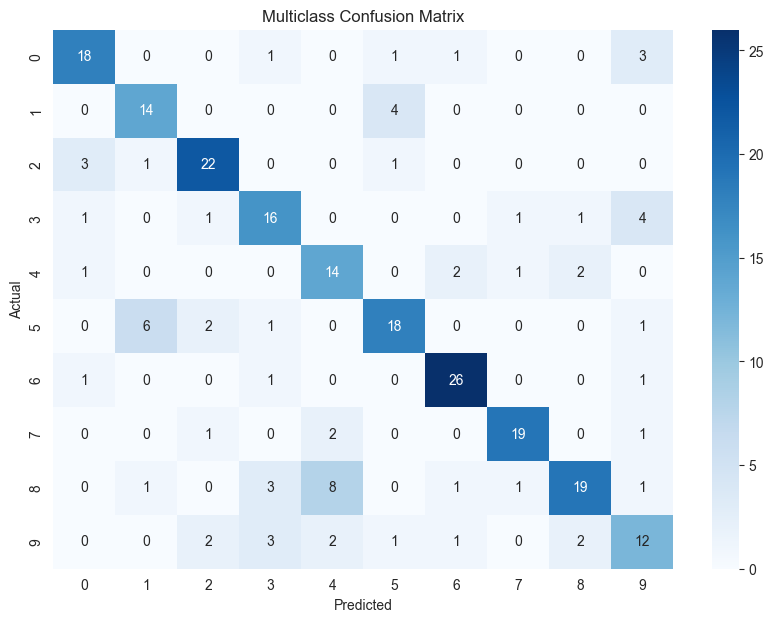

In [53]:
print(classification_report(y_true=y_test, y_pred=y_pred))
plot_confusion_matrix(y_test, predictions, labels)

Accuracy: 0.9006410256410257


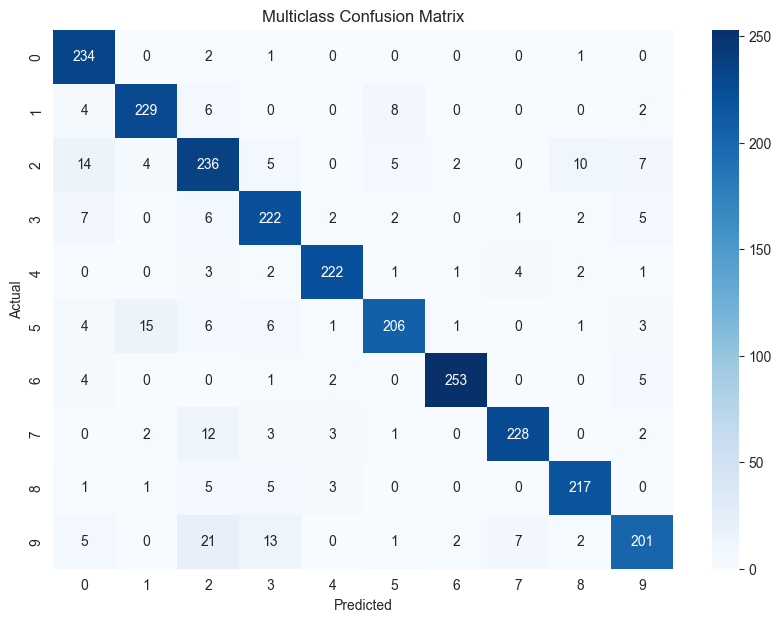

In [122]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_scaled, y_train)

predictions = clf.predict(X_test_scaled)
print('Accuracy:', accuracy_score(y_test, predictions))

# Call function:
plot_confusion_matrix(y_test, predictions, labels)

In [150]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

X_train_scaled = X_train_scaled.astype(np.float32)

input_shape = X_train_scaled.shape[1:]  # (92,)
num_classes = len(labels)

model = Sequential([
    Input(shape=(input_shape)),
    Flatten(),
    
    Dense(512, activation="relu"),
    Dropout(0.2),
    
    Dense(256,activation="relu"),
    Dropout(0.2),
    
    Dense(128,activation="relu"),
    Dropout(0.2),
    
    Dense(64,activation="relu"),
    Dropout(0.2),
    
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 512)            │        50,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,818 (874.29 KB)

 Trainable params: 223,818 (874.29 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=1
)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.2%}")

y_pred = model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ValueError: Unrecognized data type: x=[[0.8575381  0.22484978 0.48176992 ... 0.5364413  0.41528755 0.2150424 ]
 [0.17495601 0.7937097  0.6091198  ... 0.08737864 0.01873134 0.02329603]
 [0.76731944 0.4924673  0.43398514 ... 0.20580734 0.37802386 0.15112194]
 ...
 [0.78251237 0.15620595 0.62870604 ... 0.46033734 0.48771042 0.6010185 ]
 [0.6892472  0.6766435  0.5239334  ... 0.20178068 0.3839444  0.12874566]
 [0.8230996  0.2922182  0.5793012  ... 0.43201646 0.41714746 0.3327129 ]] (of type <class 'numpy.ndarray'>)